# Monthly Maps of Fine scale variance of surface relative vorticity


__author__ : Aurélie Albert & Julien Le Sommer (MEOM)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : June, 7 2018

__purpose__ : Metric for the intensity of the fine scale of surface relative vorticity in NATL60-CJM165 simulation

__detailed description__ : 
Fine scale variance is defined at a given time and space by :

$$V(X) = (X - \langle X \rangle)^{2}$$

with $\langle . \rangle$ the low pass filtering operator. An average in time and space of the variance is then defined as : 

$$\overline{(X(t)-\langle X \rangle)^{2}}^{t,x,y}$$

with $\overline{X}^{t,x,y}$ a boxcar averager.

__practical steps__ :

  Following the steps of [this notebook](cmems-glo-hr_demo-fine-scale-metrics_01_vorticity-variance_v1.0.ipynb)
  
  * step 5. : Maps of fine scale variance of relative vorticity for all month between October 2012 and September 2013
  
__external libraries needed to run this script__ : 

 * GriddedData : https://github.com/lesommer/codes/blob/master/GriddedData.py
 * WavenumberSpectrum : https://github.com/lesommer/codes/blob/master/WavenumberSpectrum.py
 * oocgcm filtering module : https://github.com/lesommer/oocgcm
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## 0. Importing external modules

In [10]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4


The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.15 64bit [GCC 7.2.0]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.2
xarray 0.10.4
netCDF4 1.4.0
Thu Jun 07 15:24:09 2018 CEST

In [11]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [12]:
## imports

import numpy as np
import xarray as xr
import GriddedData
import time

In [13]:
#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf
%matplotlib inline

## 5. Maps of fine scale variance of relative vorticity for every month between October 2012 and September 2013

In [14]:
dirin="/media/extra/DATA/NATL60/NATL60-I/"
gridfile=dirin+"NATL60_v4.1_cdf_mesh_hgr.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= np.squeeze(grid['nav_lat'])
navlon= np.squeeze(grid['nav_lon'])


/media/extra/DATA/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc


In [15]:
def fine_scale_variance(files):
    ''' from a list of files containing one month of data compute variance and average in 1°x1°x1 month boxes
    '''
    hpcurl = xr.open_mfdataset(files,concat_dim='time_counter',decode_times=False)['socurloverf_filt']
    hpcurl2 = hpcurl ** 2
    hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    return loncrsm,latcrsm,hpcurl2mcm,hpcurl2m



In [20]:
def plot_fine_scale_variance(fig,var,loncrs,latcrs,lon,lat,hpvarm,month,title,vmin,vmax):
    ''' map of the averaged fine scale variance
    '''
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    truc=np.array(hpvarm)
    truc[truc==0.]=np.nan
    cont=np.isnan(truc)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),vmin=vmin,vmax=vmax,cmap=seq_cmap,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.text(0,30,month,size=25)
    cbar.set_label(title,fontsize=25)
    return fig


In [19]:
def plot_from_file(mm):

    dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/"
    month = {1 : 'january',
           2 : 'february',
           3 : 'march',
           4 : 'april',
           5 : 'may',
           6 : 'june',
           7 : 'july',
           8 : 'august',
           9 : 'september',
           10 : 'october',
           11 : 'november',
           12 : 'december',
    }
    
    m=str(mm+1).zfill(2)
    if mm <9:
        year='2013'
    else:
        year='2012'
    filt_files='NATL60-CJM165_y'+year+'m'+str(m)+'d*.1d_socurloverf_filt-n80-f0.0125.nc'
    tf_files=dir+filt_files
    loncrsm, latcrsm, boxvarcurl, hpvarm = fine_scale_variance(tf_files)
    fig = plt.figure(figsize=(20, 15))
    truc=plot_fine_scale_variance(fig,boxvarcurl,loncrsm, latcrsm,navlon,navlat,hpvarm,month[mm+1],'Small Scale Relative Vorticity Variance',0,0.1)
    plt.savefig("NATL60_small_scale_vorticity_variance_monthly_mean_coarse_m"+m+".png")


/home/albert/anaconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


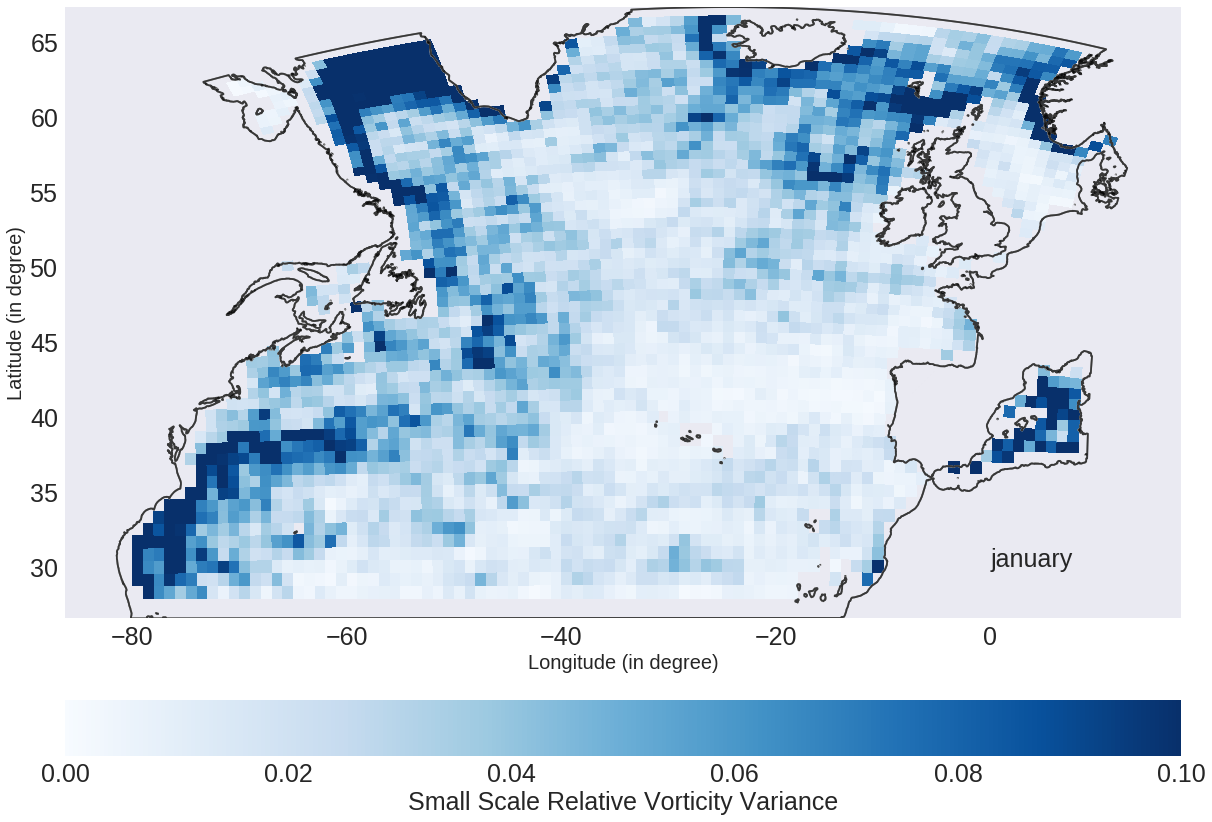

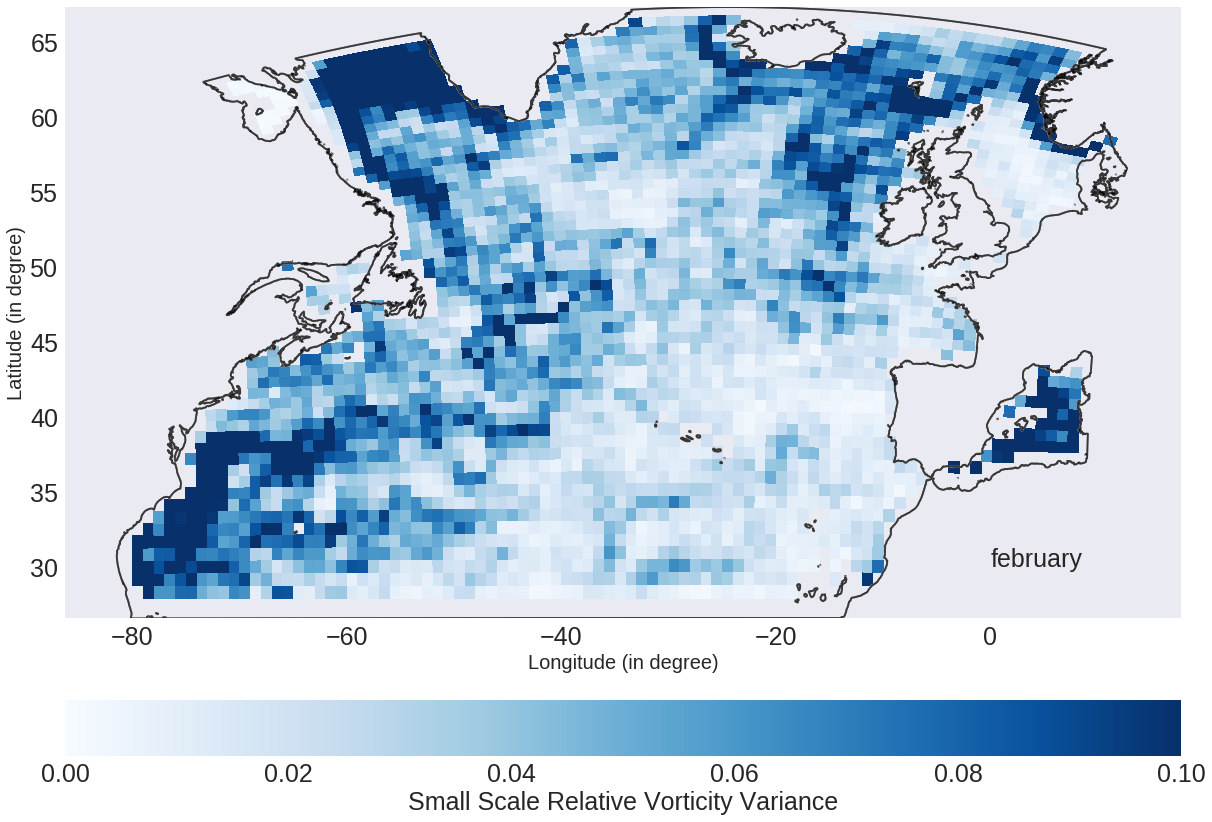

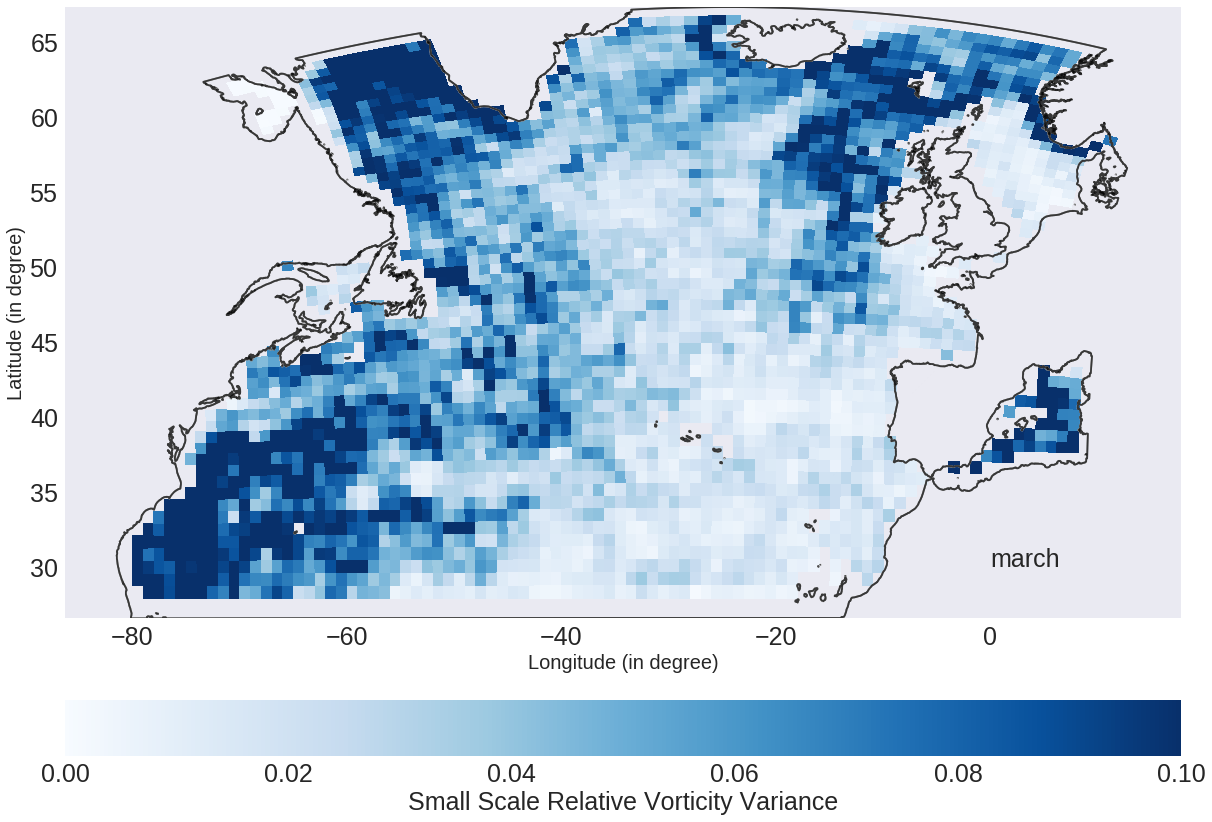

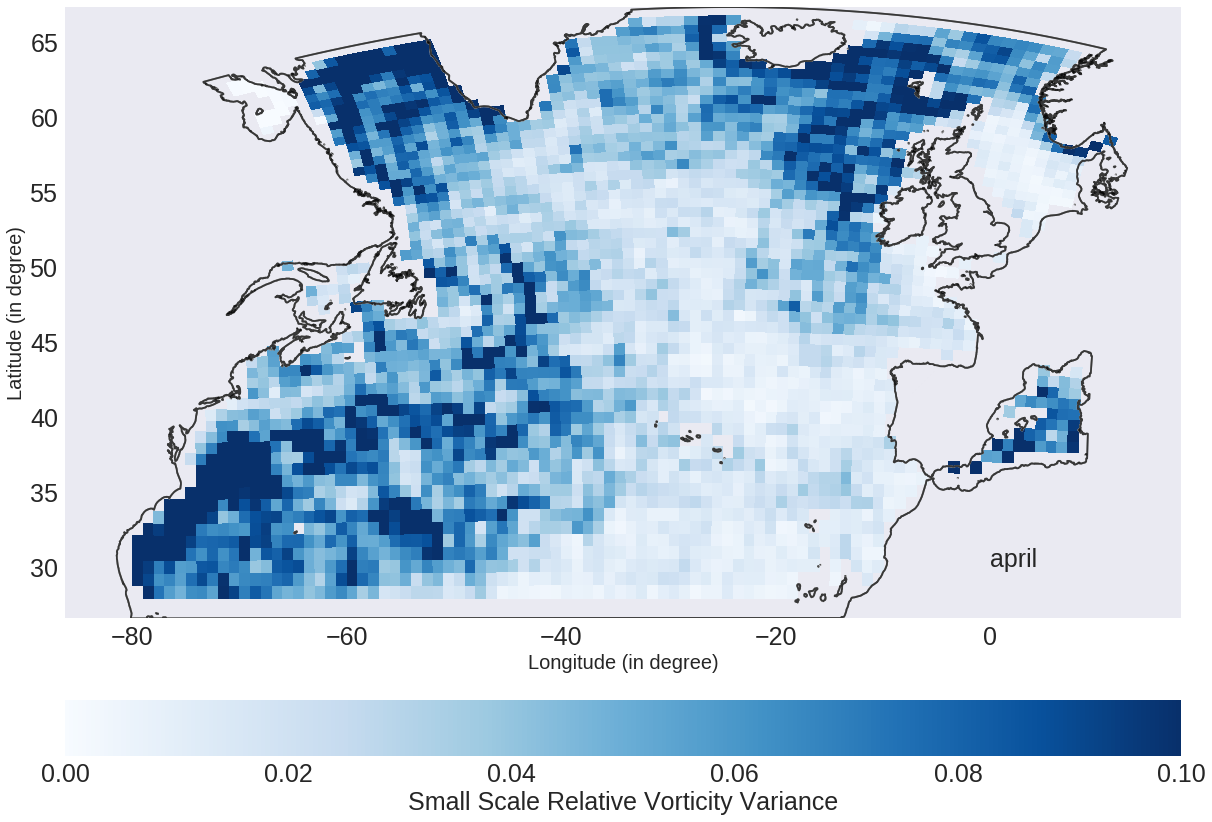

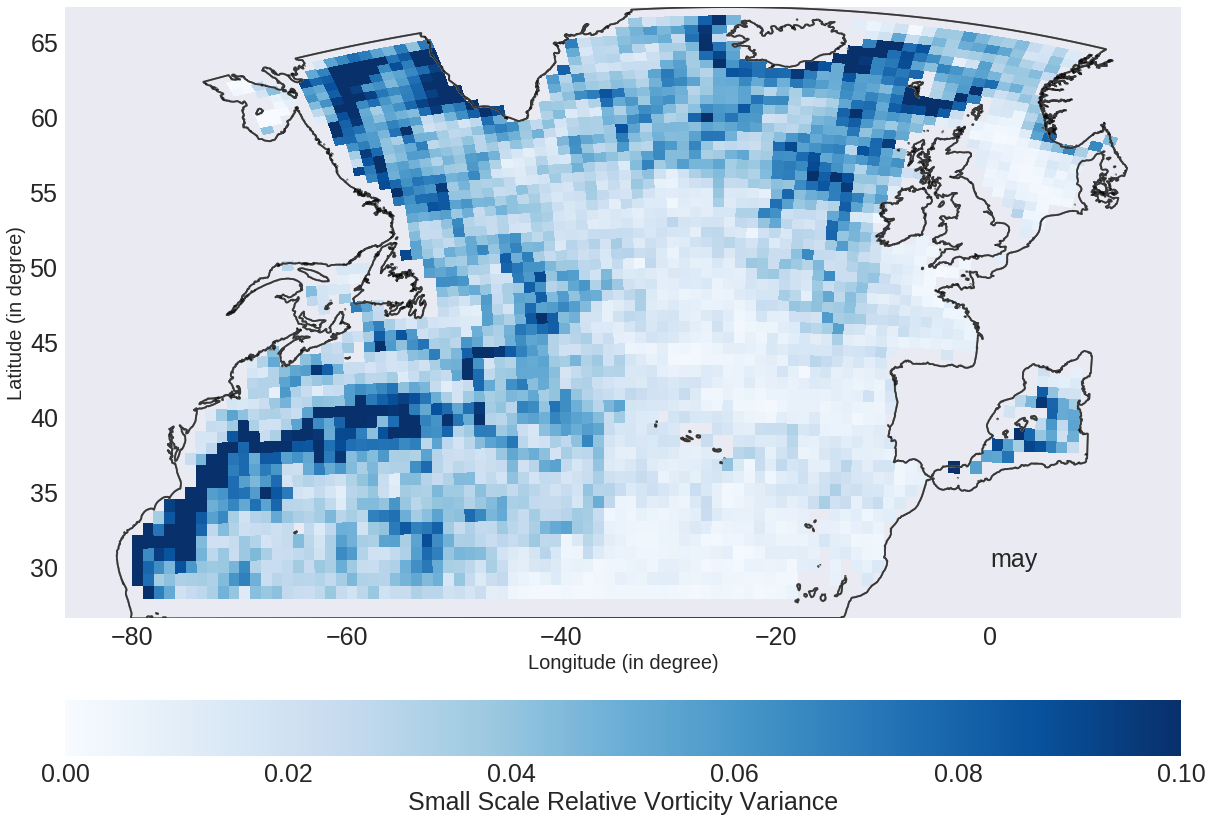

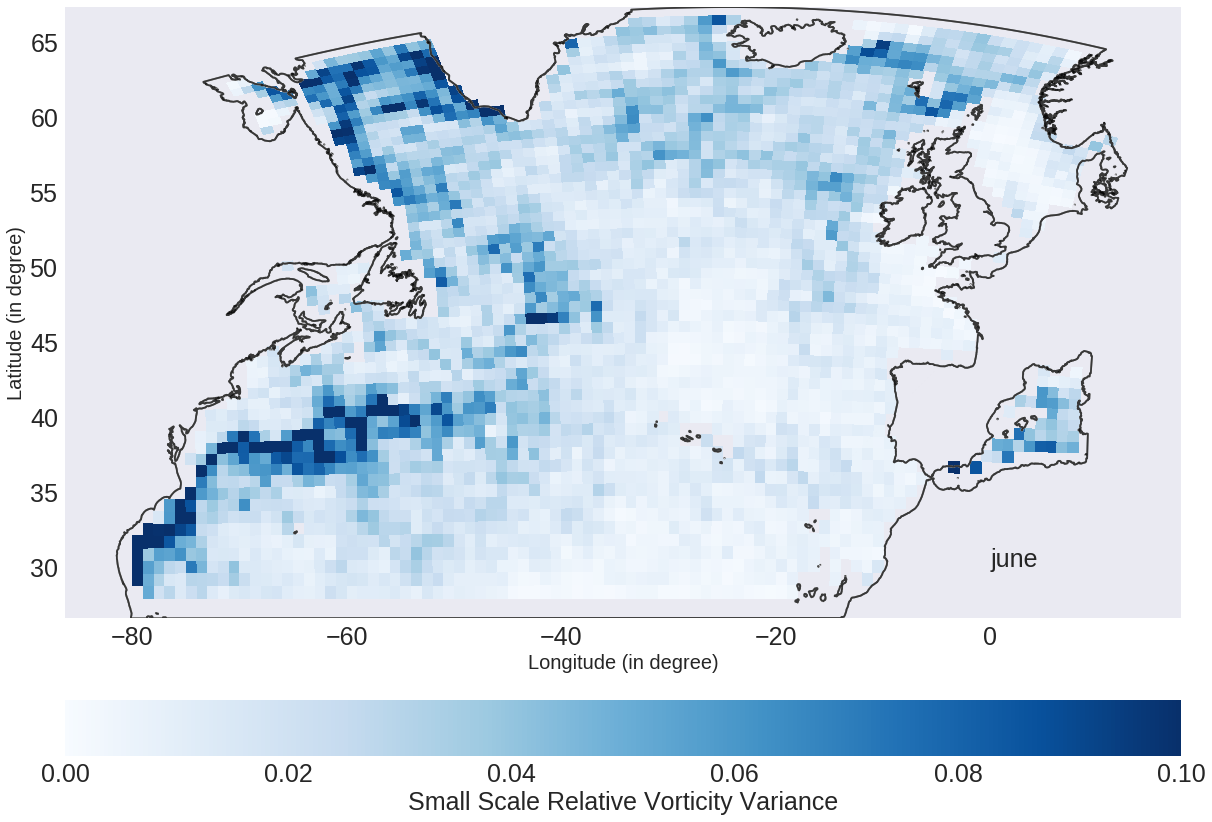

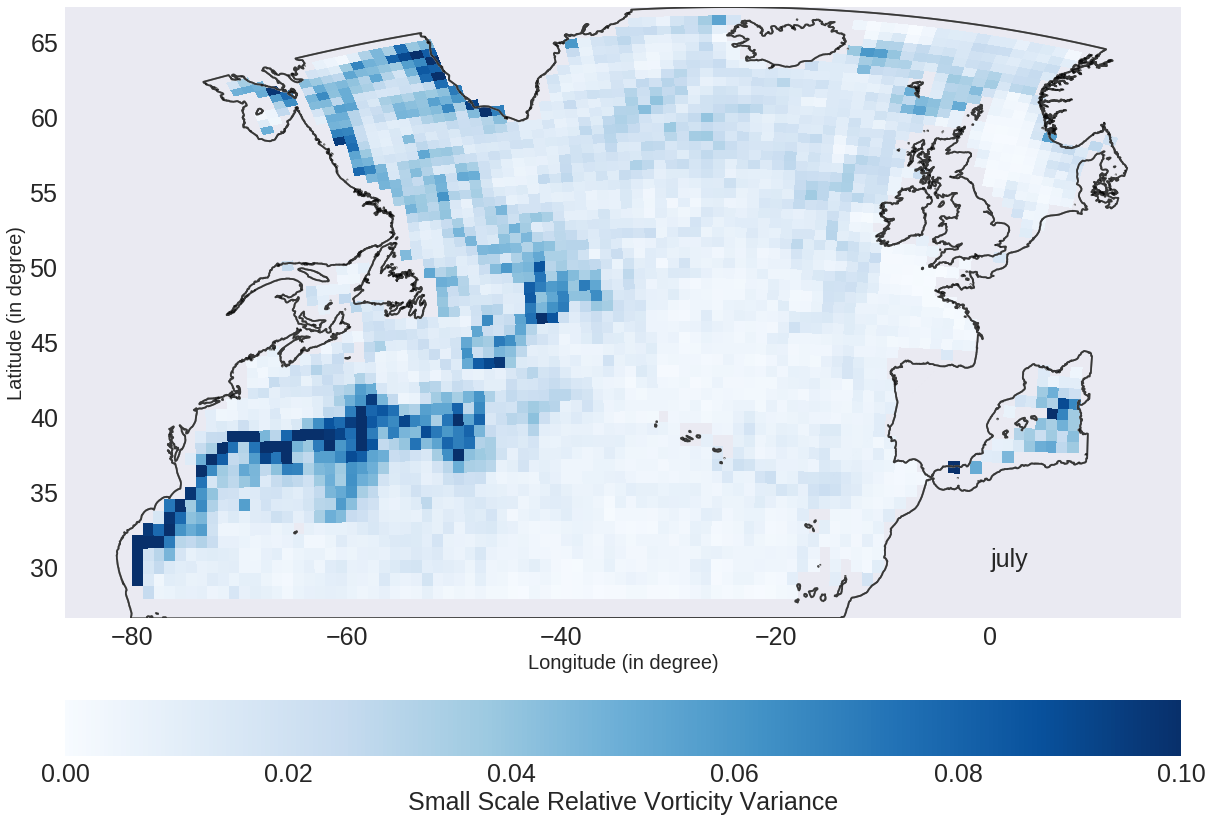

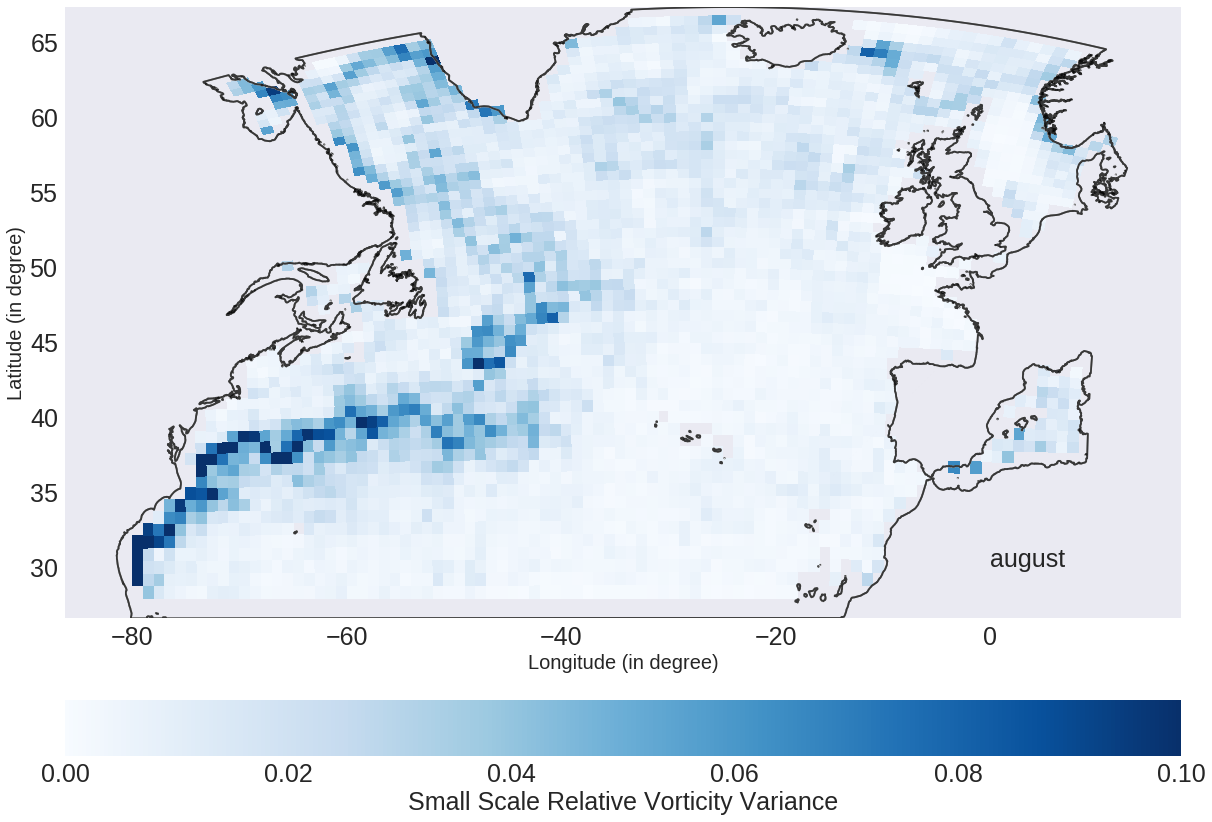

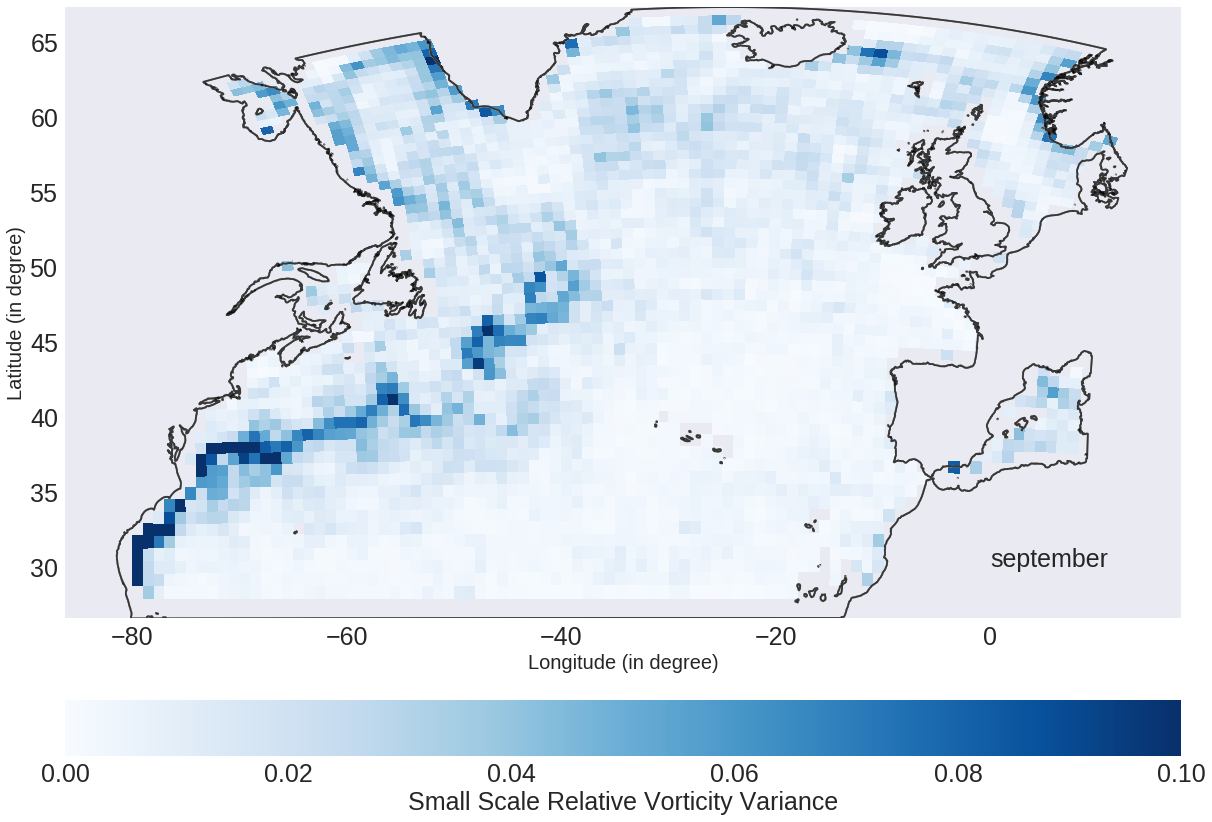

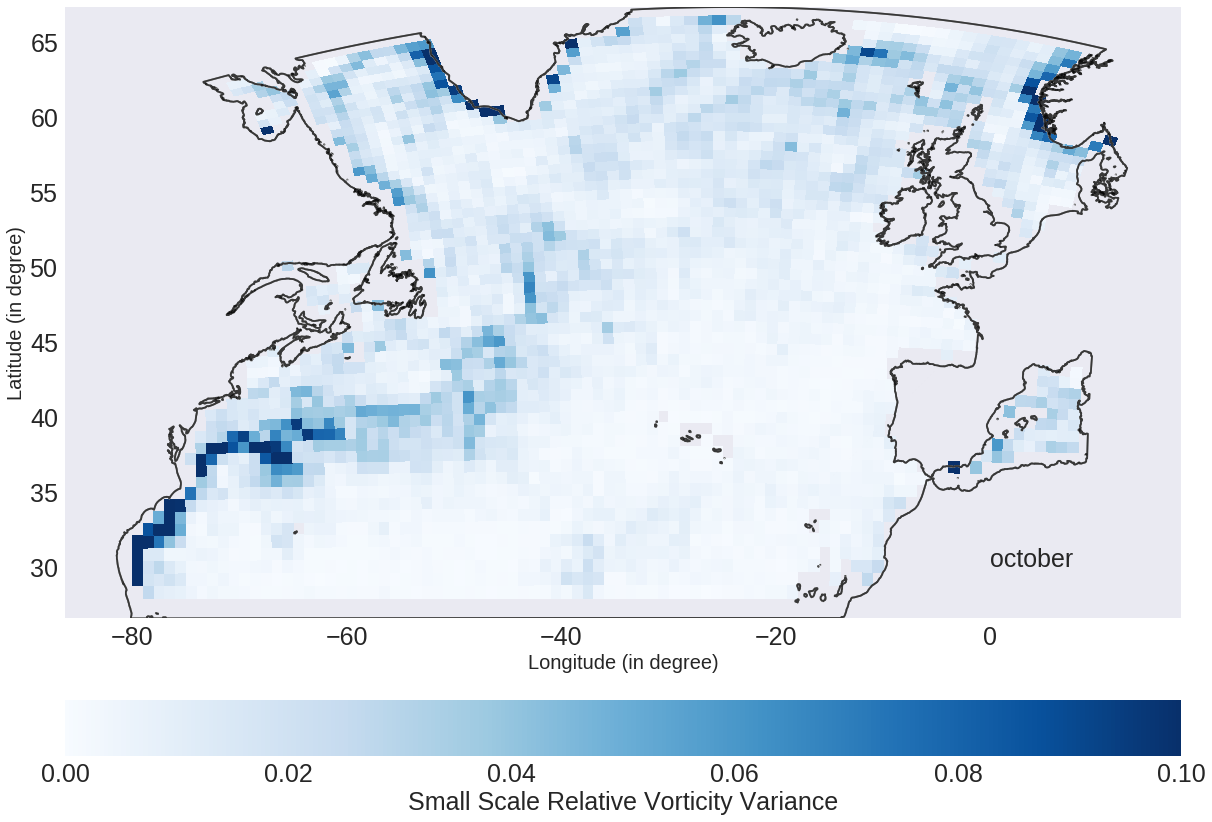

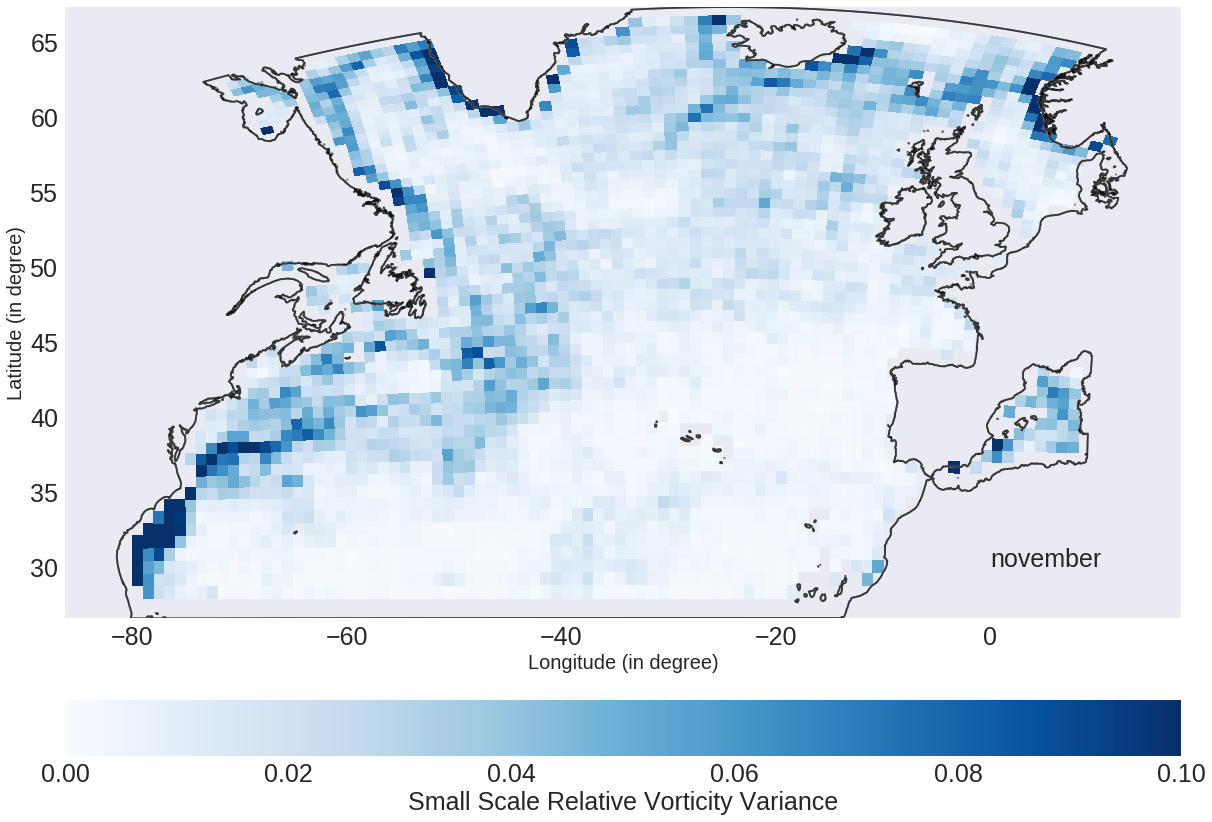

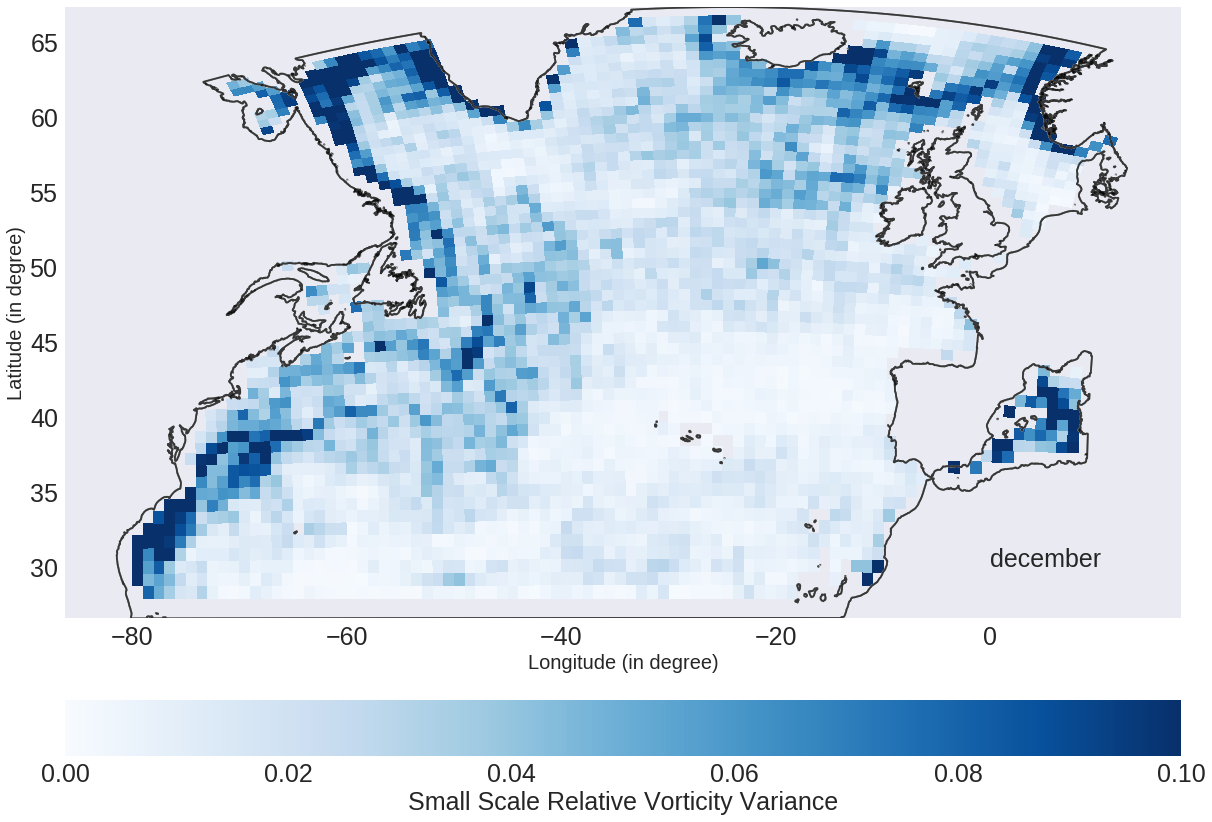

In [18]:
for k in np.arange(12):
    plot_from_file(k)